In [1]:
import torch
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

from torchlight import import_class

In [ ]:
def norm_scale(x):
    return (x-x.mean())/x.mean()


def get_CG(p, C):
    M = []
    # upper triangle index with offset 1, which means upper triangle without diagonal
    iu = torch.triu_indices(C.joint_n, C.joint_n, offset=1)
    for f in range(C.frame_l):
        # iterate all frames, calc all frame's JCD Matrix
        # p[f].shape (15,2)
        #d_m = cdist(p[f], p[f], 'euclidean')
        d_m = torch.cdist(p[f].unsqueeze(0), p[f].unsqueeze(0), p=2)[0]
        d_m = d_m[iu]
        # the upper triangle of Matrix and then flattned to a vector. Shape(105)
        M.append(d_m)
    M = torch.stack(M)
    M = norm_scale(M)  # normalize
    return M

p = torch.tensor([1,2,3,4,5])


In [3]:
data_path = r'D:\HaAnh\AimCLR-v2-main\data_cobot_clr_zoom\xsub\train_position.npy'
label_path = r'D:\HaAnh\AimCLR-v2-main\data_cobot_clr_zoom\xsub\train_label.pkl'

data_val = np.load(data_path, mmap_mode='r')
with open(label_path, 'rb') as f:
    sample_names, labels_val = pickle.load(f)
labels_val = np.array(labels_val)

In [4]:
import sys
sys.path.append(r'D:\HaAnh\AimCLR-v2-main\net')

In [5]:
model_path = r'D:\HaAnh\AimCLR-v2-main\trial4_fixconfig_512\linear\best_model.pt'

model_class = import_class('net.aimclr_v2_3views_2.AimCLR_v2_3views')
model_args = {
    'base_encoder': 'net.ddnet.DDNet_Original',
    'pretrain': False,
    'class_num': 19,
    'frame_l': 60,
    'joint_d': 3,
    'joint_n': 48,
    'filters': 16,
    'last_feture_dim': 512,
    'feat_d': 1128

}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_class(**model_args)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model = model.to(device)
model.eval()

AimCLR_v2_3views(
  (encoder_q): DDNet_Original(
    (jcd_conv1): Sequential(
      (0): c1D(
        (conv1): Conv1d(1128, 32, kernel_size=(1,), stride=(1,), bias=False)
        (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): spatialDropout1D(
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (jcd_conv2): Sequential(
      (0): c1D(
        (conv1): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): spatialDropout1D(
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (jcd_conv3): c1D(
      (conv1): Conv1d(16, 16, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (jcd_pool): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [6]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(torch.from_numpy(data_val).float())
loader = DataLoader(dataset, batch_size=32, shuffle=False)

features = []
with torch.no_grad():
    for (batch,) in loader:
        batch = batch.to(device)
        feat = model(None, batch, stream='all')
        features.append(feat.cpu())

features = torch.cat(features).numpy()
print(features.shape)


C:\Users\Nguyen Ha Anh\AppData\Local\Temp\ipykernel_1812\2370864115.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  dataset = TensorDataset(torch.from_numpy(data_val).float())
C:\Users\Nguyen Ha Anh\AppData\Roaming\Python\Python312\site-packages\torch\nn\functional.py:1542: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (

(1481, 19)


In [7]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_2d = tsne.fit_transform(features)
print("t-SNE done. Shape:", features_2d.shape)


t-SNE done. Shape: (1481, 2)


In [8]:

n_clusters = 19
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features)
nmi_score = normalized_mutual_info_score(labels_val, cluster_labels)
print(f"NMI Score: {nmi_score:.4f}")


NMI Score: 0.5848


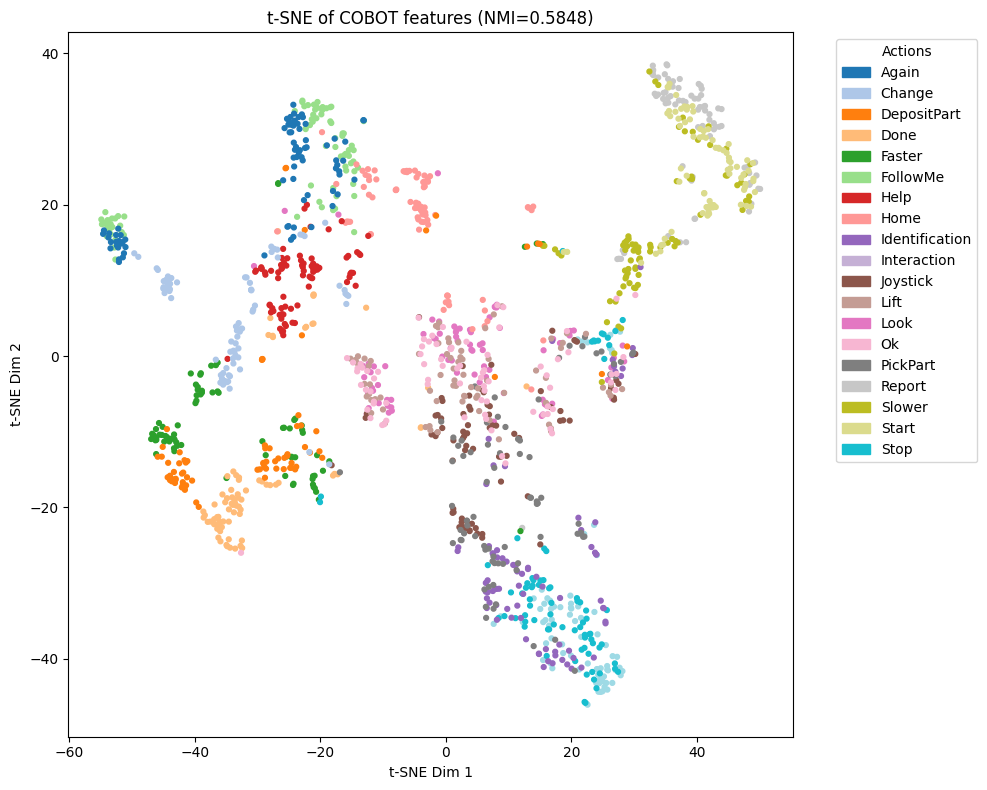

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Action names (the same order như labels_val)
action_names = [
    'Again', 'Change', 'DepositPart', 'Done', 'Faster', 'FollowMe',
    'Help', 'Home', 'Identification', 'Interaction', 'Joystick',
    'Lift', 'Look', 'Ok', 'PickPart', 'Report', 'Slower', 'Start', 'Stop'
]

plt.figure(figsize=(10,8))

# Scatter plot
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels_val, cmap='tab20', s=12)

# Create legend manually
handles = []
for i, name in enumerate(action_names):
    handles.append(mpatches.Patch(color=plt.cm.tab20(i/19), label=name))
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Actions")

plt.title(f"t-SNE of COBOT features (NMI={nmi_score:.4f})")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.tight_layout()
plt.show()


In [12]:
import time
batch_size = 1
times = []

# Warm-up 
with torch.no_grad():
    for i in range(0, len(labels_val), batch_size):
        batch_data = data_val[i:i+batch_size]
        batch_tensor = torch.from_numpy(batch_data).float().to(device)
        batch_features = model(None, batch_tensor, stream='all') 
        if device == 'cuda':
            torch.cuda.synchronize()

# Timed loop
with torch.no_grad():
    for i in range(0, len(labels_val), batch_size):
        batch_data = data_val[i:i+batch_size]
        batch_tensor = torch.from_numpy(batch_data).float().to(device)
        start = time.time()
        batch_features = model(None, batch_tensor, stream='all') 
        if device == 'cuda':
            torch.cuda.synchronize()
        end = time.time()
        
        times.append(end - start)


avg_time_ms = np.mean(times) * 1000
print(f"Average inference time per sample: {avg_time_ms:.2f} ms")


Average inference time per sample: 66.39 ms


In [14]:
import torch
import time

model.eval()  # always do this for inference

# prepare input ONCE, not inside timing
batch_tensor = torch.from_numpy(data_val[0:1]).float().to(device)

# warm-up
with torch.no_grad():
    for _ in range(10):
        model(None, batch_tensor, stream='all')

if device == 'cuda':
    torch.cuda.synchronize()

# timing exactly 1 forward
with torch.no_grad():
    if device == 'cuda':
        torch.cuda.synchronize()

    start = time.perf_counter()
    model(None, batch_tensor, stream='all')

    if device == 'cuda':
        torch.cuda.synchronize()
    end = time.perf_counter()

elapsed_ms = (end - start) * 1000
print(f"Inference time (1 forward): {elapsed_ms:.4f} ms")


Inference time (1 forward): 75.4638 ms


In [10]:
model_path = r'D:\HaAnh\AimCLR-v2-main\trial4_fixconfig_512\pretext\epoch400_model.pt'

model_class = import_class('net.aimclr_v2_3views_2.AimCLR_v2_3views')
model_args = {
    'base_encoder': 'net.ddnet.DDNet_Original',
    'Temperature': 0.3,
    'pretrain': True,
    'momentum': 0.999,
    'queue_size': 2048,
    'mlp':True,
    'class_num': 19,
    'frame_l': 60,
    'joint_d': 3,
    'joint_n': 48,
    'filters': 16,
    'last_feture_dim': 512,
    'feat_d': 1128

}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_class(**model_args)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model = model.to(device)
model.eval()

AimCLR_v2_3views(
  (encoder_q): DDNet_Original(
    (jcd_conv1): Sequential(
      (0): c1D(
        (conv1): Conv1d(1128, 32, kernel_size=(1,), stride=(1,), bias=False)
        (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): spatialDropout1D(
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (jcd_conv2): Sequential(
      (0): c1D(
        (conv1): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): spatialDropout1D(
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
    )
    (jcd_conv3): c1D(
      (conv1): Conv1d(16, 16, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (jcd_pool): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(torch.from_numpy(data_val).float())
loader = DataLoader(dataset, batch_size=32, shuffle=False)

features = []
with torch.no_grad():
    for (batch,) in loader:
        batch = batch.to(device)
        feat = model(None, batch, stream='all')
        features.append(feat.cpu())

features = torch.cat(features).numpy()
print(features.shape)
